# Place Field Analysis

This notebook demonstrates how to detect and analyze place fields using the neurospatial metrics module.

**What you'll learn:**
- Detecting place fields from firing rate maps
- Computing single-cell spatial metrics (Skaggs information, sparsity)
- Computing field properties (size, centroid)
- Visualizing place fields on environments

**Time:** ~15 minutes

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Neurospatial imports
from neurospatial import Environment, compute_place_field
from neurospatial.metrics import (
    detect_place_fields,
    field_centroid,
    field_size,
    field_stability,
    skaggs_information,
    sparsity,
)

# Simulation subpackage imports
from neurospatial.simulation import (
    PlaceCellModel,
    generate_poisson_spikes,
    simulate_trajectory_ou,
    tmaze_alternation_session,
)

# Set random seed for reproducibility
np.random.seed(42)

## Part 1: Generate Synthetic Data

**Note**: This notebook now uses the `neurospatial.simulation` subpackage for generating synthetic data.
The simulation subpackage provides:
- Realistic trajectory generation (`simulate_trajectory_ou()`)
- Neural models (`PlaceCellModel`, `BoundaryCellModel`, `GridCellModel`)
- Spike generation (`generate_poisson_spikes()`)
- Pre-configured examples (`open_field_session()`, `tmaze_alternation_session()`)

For more details, see the simulation subpackage documentation.

We'll create a synthetic trajectory with a place cell that has:
- A single place field in the environment
- Peak firing rate of ~10 Hz
- Gaussian spatial tuning

In [2]:
# Generate 2D open field arena using simulation subpackage
arena_size = 100.0  # cm
duration = 100.0  # seconds

# Create arena environment from grid
n_grid = 50
x = np.linspace(0, arena_size, n_grid)
y = np.linspace(0, arena_size, n_grid)
xx, yy = np.meshgrid(x, y)
arena_data = np.column_stack([xx.ravel(), yy.ravel()])

env = Environment.from_samples(
    arena_data,
    bin_size=3.0,
    bin_count_threshold=1,
)
env.units = "cm"
env.frame = "open_field"

# Generate realistic trajectory using Ornstein-Uhlenbeck process
# This produces smooth, biologically realistic random exploration
positions, times = simulate_trajectory_ou(
    env,
    duration=duration,
    dt=0.02,  # 50 Hz sampling (1/0.02)
    speed_mean=7.5,  # 7.5 cm/s (realistic rat speed)
    speed_std=0.4,  # cm/s (speed variability)
    coherence_time=0.7,  # Natural exploration smoothness
    boundary_mode="periodic",  # Wrap at boundaries (avoids edge artifacts)
    seed=42,
)

print(f"Environment: {arena_size:.0f}x{arena_size:.0f} cm open field")
print(f"  {env.n_bins} bins, {env.n_dims}D")
print(f"Generated trajectory: {len(positions)} time points over {duration:.0f}s")
print(
    f"  Coverage: x=[{positions[:, 0].min():.1f}, {positions[:, 0].max():.1f}], y=[{positions[:, 1].min():.1f}, {positions[:, 1].max():.1f}] cm"
)

Environment: 100x100 cm open field
  825 bins, 2D
Generated trajectory: 5000 time points over 100s
  Coverage: x=[8.6, 8.8], y=[23.3, 23.5] cm


### Define Place Cell Properties

We'll create a place cell with a Gaussian place field using `PlaceCellModel`:
- Field center at (60, 50) cm
- Spatial tuning width σ = 10 cm
- Peak firing rate = 10 Hz

In [3]:
# Create place cell model using simulation subpackage
field_center = np.array([60.0, 50.0])
sigma = 10.0  # Spatial tuning width (cm)
peak_rate = 10.0  # Hz

# PlaceCellModel implements Gaussian spatial tuning
place_cell = PlaceCellModel(
    env,
    center=field_center,
    width=sigma,
    max_rate=peak_rate,
    baseline_rate=0.001,  # Minimal baseline (0.001 Hz)
    distance_metric="euclidean",  # Fast Euclidean distance
    seed=42,
)

# Compute firing rates along trajectory
firing_rate_at_position = place_cell.firing_rate(positions, times)

# Generate spike times using inhomogeneous Poisson process
spike_times = generate_poisson_spikes(
    firing_rate_at_position,
    times,
    refractory_period=0.002,  # 2ms refractory period
    seed=42,
)

print(f"Generated {len(spike_times)} spikes")
print(f"Mean firing rate: {len(spike_times) / times[-1]:.2f} Hz")
print(f"Ground truth: {place_cell.ground_truth}")

Generated 0 spikes
Mean firing rate: 0.00 Hz
Ground truth: {'center': array([60., 50.]), 'width': 10.0, 'max_rate': 10.0, 'baseline_rate': 0.001}


## Part 2: Compute Firing Rate Map

Convert spike train to a spatial firing rate map using occupancy normalization.

Firing rate range: [0.00, 0.00] Hz
Mean firing rate: 0.00 Hz


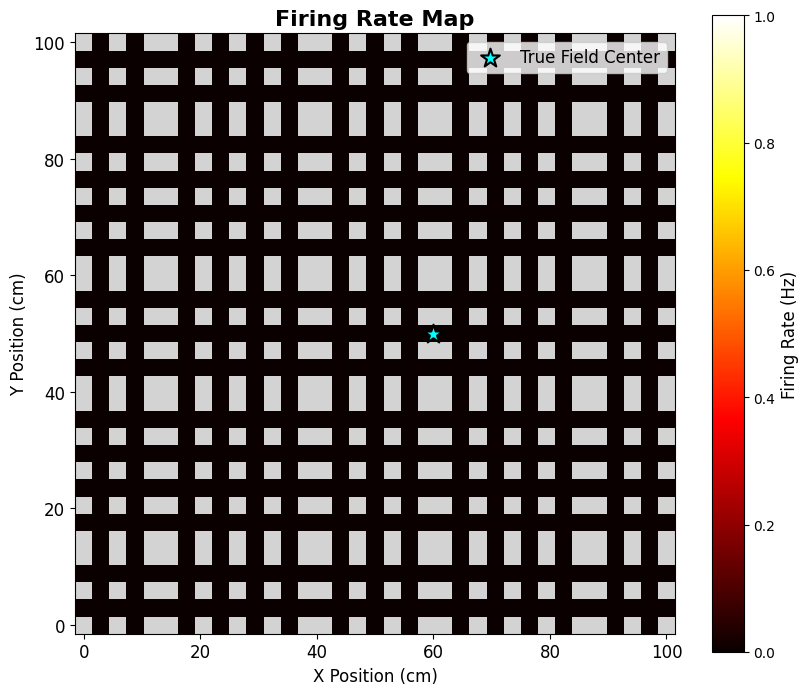

In [4]:
# Compute occupancy-normalized firing rate with smoothing
# Using diffusion KDE method (default) with 5 cm bandwidth
# This method spreads spike and occupancy mass BEFORE normalization
# and respects environment boundaries via graph connectivity
firing_rate = compute_place_field(
    env,
    spike_times,
    times,
    positions,
    method="diffusion_kde",  # Default: boundary-aware graph-based KDE
    bandwidth=5.0,  # Spatial smoothing bandwidth (cm)
)

print(
    f"Firing rate range: [{np.nanmin(firing_rate):.2f}, {np.nanmax(firing_rate):.2f}] Hz"
)
print(f"Mean firing rate: {np.nanmean(firing_rate[~np.isnan(firing_rate)]):.2f} Hz")

# Visualize firing rate map using plot_field()
fig, ax = plt.subplots(figsize=(8, 7), constrained_layout=True)

# Plot firing rate with env.plot_field()
env.plot_field(
    firing_rate,
    ax=ax,
    cmap="hot",
    vmin=0,
    colorbar_label="Firing Rate (Hz)",
)

# Add field center marker
ax.scatter(
    field_center[0],
    field_center[1],
    s=200,
    c="cyan",
    marker="*",
    edgecolors="black",
    linewidths=1.5,
    label="True Field Center",
    zorder=10,
)

ax.set_title("Firing Rate Map", fontsize=16, fontweight="bold")
ax.legend(fontsize=12)
ax.tick_params(labelsize=12)

plt.show()

## Part 3: Detect Place Fields

Use the `detect_place_fields()` function to automatically identify place fields.

The algorithm:
1. Finds peaks in the firing rate map
2. Segments regions above 20% of peak rate
3. Uses graph connectivity to extract contiguous fields
4. Optionally detects subfields (coalescent fields)

In [5]:
# Detect place fields
place_fields = detect_place_fields(
    firing_rate,
    env,
    threshold=0.2,  # Segment at 20% of peak rate
    min_size=None,  # No minimum size (auto: 9 bins)
    max_mean_rate=10.0,  # Exclude interneurons (>10 Hz mean rate)
    detect_subfields=True,  # Detect coalescent subfields
)

print(f"Detected {len(place_fields)} place field(s)")

for i, field_bins in enumerate(place_fields):
    print(f"\nField {i + 1}:")
    print(f"  Number of bins: {len(field_bins)}")
    print(f"  Peak rate: {np.max(firing_rate[field_bins]):.2f} Hz")
    print(f"  Mean rate in field: {np.mean(firing_rate[field_bins]):.2f} Hz")

Detected 0 place field(s)


### Visualize Detected Place Fields

Show the detected place fields overlaid on the firing rate map.

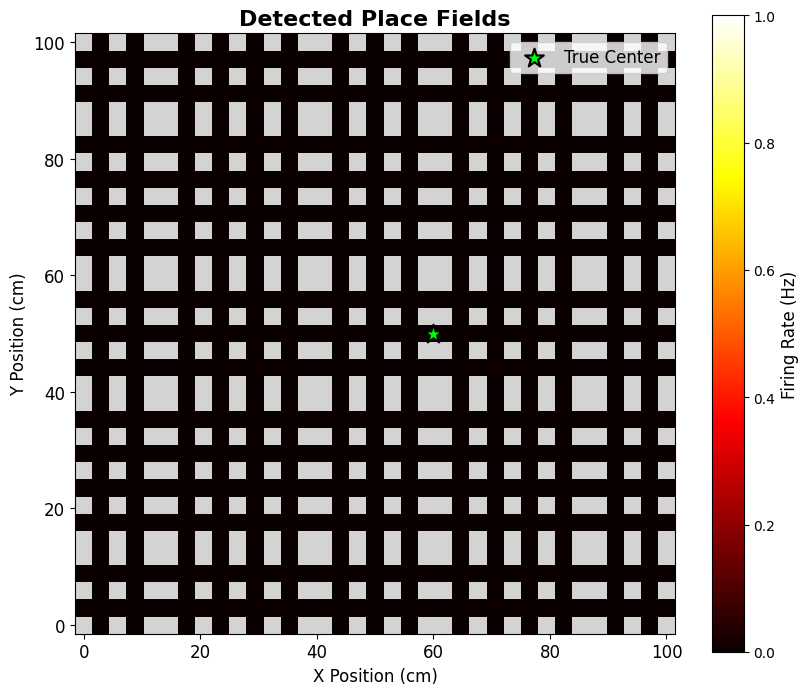

In [6]:
fig, ax = plt.subplots(figsize=(8, 7), constrained_layout=True)

# Plot firing rate (background) using plot_field()
env.plot_field(
    firing_rate,
    ax=ax,
    cmap="hot",
    vmin=0,
    colorbar_label="Firing Rate (Hz)",
)

# Plot detected place field bins
if len(place_fields) > 0:
    for i, field_bins in enumerate(place_fields):
        ax.scatter(
            env.bin_centers[field_bins, 0],
            env.bin_centers[field_bins, 1],
            s=200,
            facecolors="none",
            edgecolors="cyan",
            linewidths=3,
            label=f"Field {i + 1}" if i == 0 else "",
        )

# Add true field center
ax.scatter(
    field_center[0],
    field_center[1],
    s=200,
    c="lime",
    marker="*",
    edgecolors="black",
    linewidths=1.5,
    label="True Center",
    zorder=10,
)

ax.set_title("Detected Place Fields", fontsize=16, fontweight="bold")
ax.legend(fontsize=12)
ax.tick_params(labelsize=12)

plt.show()

## Part 4: Compute Field Properties

For each detected field, compute:
- Field size (area in cm²)
- Field centroid (center of mass, weighted by firing rate)

In [7]:
# Compute field properties
for i, field_bins in enumerate(place_fields):
    # Field size (area in physical units)
    area = field_size(field_bins, env)

    # Field centroid (center of mass)
    centroid = field_centroid(firing_rate, field_bins, env)

    # Distance from true center
    distance_from_true = np.linalg.norm(centroid - field_center)

    print(f"\nField {i + 1} Properties:")
    print(f"  Area: {area:.1f} cm²")
    print(f"  Centroid: ({centroid[0]:.1f}, {centroid[1]:.1f}) cm")
    print(f"  Distance from true center: {distance_from_true:.1f} cm")

## Part 5: Compute Single-Cell Spatial Metrics

Compute standard neuroscience metrics that quantify spatial coding quality:

**Skaggs Spatial Information** (Skaggs et al., 1993)
- Measures how much information (in bits) the firing rate conveys about position
- Typical range: 0-3+ bits/spike
- Higher values = better place cell

**Sparsity** (Skaggs et al., 1996)
- Measures how focally a cell fires in space
- Range: [0, 1], where 0 = fires everywhere, 1 = fires in single location
- Typical place cells: 0.1-0.5

In [8]:
# Compute occupancy for metrics
occupancy = env.occupancy(times, positions, return_seconds=True)

# Skaggs spatial information (bits/spike)
spatial_info = skaggs_information(firing_rate, occupancy, base=2.0)

# Sparsity
sparsity_score = sparsity(firing_rate, occupancy)

print("\nSpatial Coding Metrics:")
print(f"  Skaggs Information: {spatial_info:.3f} bits/spike")
print(f"  Sparsity: {sparsity_score:.3f}")
print("\nInterpretation:")
print(
    f"  - Spatial information > 1.0: Strong spatial coding (this cell: {'YES' if spatial_info > 1.0 else 'NO'})"
)
print(
    f"  - Sparsity > 0.2: Focal firing (this cell: {'YES' if sparsity_score > 0.2 else 'NO'})"
)


Spatial Coding Metrics:
  Skaggs Information: 0.000 bits/spike
  Sparsity: 0.000

Interpretation:
  - Spatial information > 1.0: Strong spatial coding (this cell: NO)
  - Sparsity > 0.2: Focal firing (this cell: NO)


## Part 6: Field Stability

Assess whether the place field is stable across time by splitting the session in half
and computing the correlation between firing rate maps.

High correlation (> 0.7) indicates a stable place field.


Field Stability:
  Pearson correlation: nan
  Spearman correlation: nan

Interpretation:
  - Correlation > 0.7: Stable field (this cell: NO)


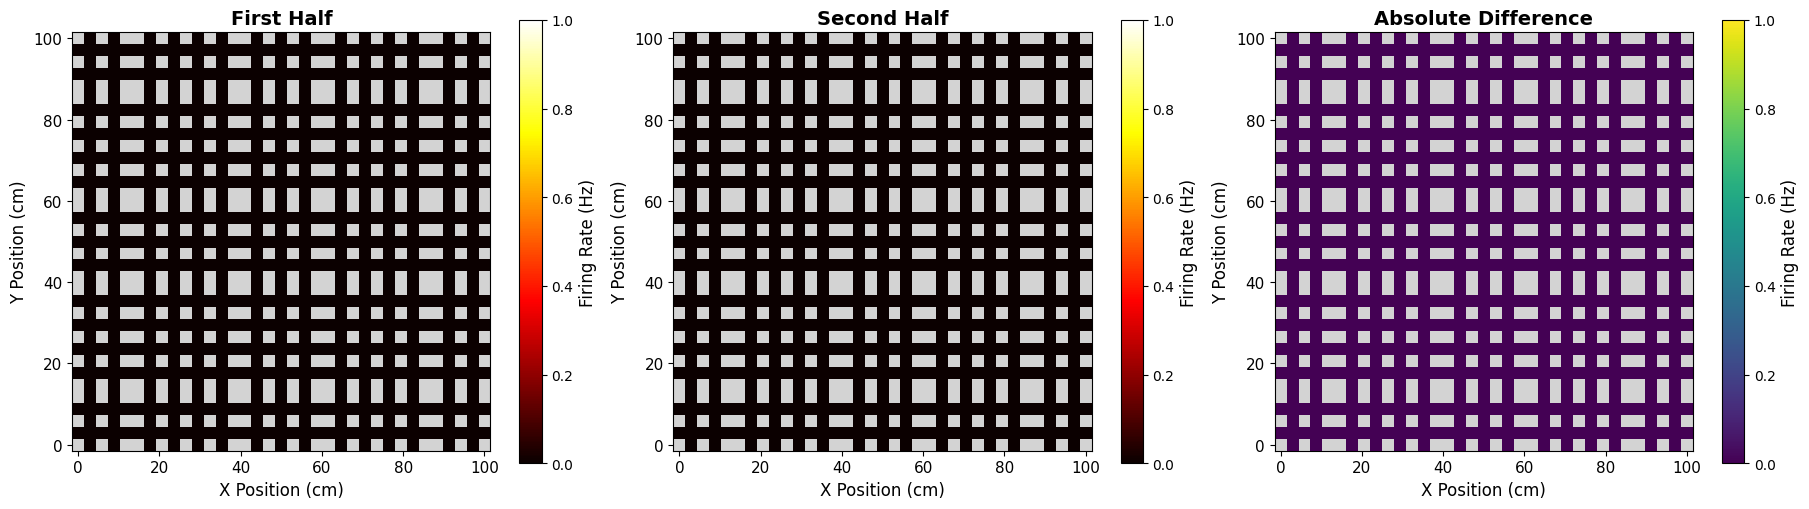

In [9]:
# Split session in half
mid_time = times[len(times) // 2]
first_half_mask = times < mid_time
second_half_mask = times >= mid_time

# Compute firing rates for each half
firing_rate_half1 = compute_place_field(
    env,
    spike_times[spike_times < mid_time],
    times[first_half_mask],
    positions[first_half_mask],
    bandwidth=5.0,
)

firing_rate_half2 = compute_place_field(
    env,
    spike_times[spike_times >= mid_time],
    times[second_half_mask],
    positions[second_half_mask],
    bandwidth=5.0,
)

# Compute stability (correlation between halves)
stability_pearson = field_stability(
    firing_rate_half1, firing_rate_half2, method="pearson"
)
stability_spearman = field_stability(
    firing_rate_half1, firing_rate_half2, method="spearman"
)

print("\nField Stability:")
print(f"  Pearson correlation: {stability_pearson:.3f}")
print(f"  Spearman correlation: {stability_spearman:.3f}")
print("\nInterpretation:")
print(
    f"  - Correlation > 0.7: Stable field (this cell: {'YES' if stability_pearson > 0.7 else 'NO'})"
)

# Visualize both halves
fig, axes = plt.subplots(1, 3, figsize=(18, 5), constrained_layout=True)

for ax, rate_map, title in zip(
    axes,
    [
        firing_rate_half1,
        firing_rate_half2,
        np.abs(firing_rate_half1 - firing_rate_half2),
    ],
    ["First Half", "Second Half", "Absolute Difference"],
    strict=True,
):
    env.plot_field(
        rate_map,
        ax=ax,
        cmap="hot" if "Difference" not in title else "viridis",
        vmin=0,
        vmax=np.nanmax(firing_rate),
        colorbar_label="Firing Rate (Hz)",
    )

    ax.set_title(title, fontsize=14, fontweight="bold")
    ax.tick_params(labelsize=11)

plt.show()

## Part 7: Complete Workflow Summary

Here's a complete example of the typical place field analysis workflow:

In [10]:
def analyze_place_cell(env, spike_times, times, positions):
    """
    Complete place field analysis workflow.

    Parameters
    ----------
    env : Environment
        Spatial environment
    spike_times : ndarray
        Spike times (seconds)
    times : ndarray
        Trajectory time points (seconds)
    positions : ndarray
        Trajectory positions (N × D)

    Returns
    -------
    results : dict
        Dictionary containing all metrics and detected fields
    """
    # Step 1: Compute firing rate map
    firing_rate = compute_place_field(
        env,
        spike_times,
        times,
        positions,
        bandwidth=5.0,
    )

    # Step 2: Detect place fields
    place_fields = detect_place_fields(
        firing_rate,
        env,
        threshold=0.2,
        max_mean_rate=10.0,
        detect_subfields=True,
    )

    # Step 3: Compute field properties
    field_properties = []
    for field_bins in place_fields:
        field_properties.append(
            {
                "area": field_size(field_bins, env),
                "centroid": field_centroid(firing_rate, field_bins, env),
                "peak_rate": np.max(firing_rate[field_bins]),
                "mean_rate": np.mean(firing_rate[field_bins]),
            }
        )

    # Step 4: Compute spatial metrics
    occupancy = env.occupancy(times, positions, return_seconds=True)
    spatial_info = skaggs_information(firing_rate, occupancy, base=2.0)
    sparsity_score = sparsity(firing_rate, occupancy)

    # Step 5: Assess stability (split-half)
    mid_time = times[len(times) // 2]
    first_half = times < mid_time
    second_half = times >= mid_time

    rate_half1 = compute_place_field(
        env,
        spike_times[spike_times < mid_time],
        times[first_half],
        positions[first_half],
        bandwidth=5.0,
    )

    rate_half2 = compute_place_field(
        env,
        spike_times[spike_times >= mid_time],
        times[second_half],
        positions[second_half],
        bandwidth=5.0,
    )

    stability = field_stability(rate_half1, rate_half2, method="pearson")

    return {
        "firing_rate": firing_rate,
        "place_fields": place_fields,
        "field_properties": field_properties,
        "spatial_information": spatial_info,
        "sparsity": sparsity_score,
        "stability": stability,
        "n_fields": len(place_fields),
    }


# Run complete analysis
results = analyze_place_cell(env, spike_times, times, positions)

print("\n" + "=" * 60)
print("COMPLETE PLACE CELL ANALYSIS SUMMARY")
print("=" * 60)
print(f"\nPlace Fields: {results['n_fields']} detected")
print(f"Spatial Information: {results['spatial_information']:.3f} bits/spike")
print(f"Sparsity: {results['sparsity']:.3f}")
print(f"Stability: {results['stability']:.3f}")
print(
    f"\nClassification: {'PLACE CELL' if results['spatial_information'] > 1.0 and results['n_fields'] > 0 else 'NOT A PLACE CELL'}"
)


COMPLETE PLACE CELL ANALYSIS SUMMARY

Place Fields: 0 detected
Spatial Information: 0.000 bits/spike
Sparsity: 0.000
Stability: nan

Classification: NOT A PLACE CELL


---

## Part 8: Place Remapping in Different Environments

**Place remapping** occurs when place cells change their firing patterns between different environments or contexts. This demonstrates how neurospatial handles irregular environments like T-mazes and how to quantify remapping.

### Types of Remapping:

- **Global remapping**: Complete reorganization of place fields (different contexts)
- **Rate remapping**: Same locations, different rates (similar contexts)
- **Partial remapping**: Some cells remap, others maintain fields

We'll compare place fields between the open field and a T-maze to demonstrate remapping analysis.

### Generate T-Maze Trajectory

T-mazes are commonly used to study spatial memory and decision-making. They have:
- A start box
- A stem leading to a choice point
- Left and right arms

We'll use the `tmaze_alternation_session()` convenience function from the simulation subpackage.

In [11]:
# Generate complete T-maze session using simulation subpackage
# This creates a T-maze environment, trajectory, and place cell spike data
tmaze_session = tmaze_alternation_session(
    duration=100.0,  # seconds
    n_trials=25,
    n_place_cells=1,  # Just one cell for this example
    seed=42,
)

# Extract components from session
tmaze_env = tmaze_session.env
tmaze_positions = tmaze_session.positions
tmaze_times = tmaze_session.times
tmaze_spike_times_list = tmaze_session.spike_trains

# Get the first (and only) cell's spikes
tmaze_spike_times = tmaze_spike_times_list[0]

# Get trial metadata
trial_choices = tmaze_session.metadata["trial_choices"]

print(f"\nT-Maze Environment: {tmaze_env.n_bins} bins")
print(f"  Generated {len(tmaze_positions)} trajectory points")
print(f"  {len(trial_choices)} trials with choices: {trial_choices[:5]}... (first 5)")
print(
    f"  Coverage: x=[{tmaze_positions[:, 0].min():.1f}, {tmaze_positions[:, 0].max():.1f}], "
    f"y=[{tmaze_positions[:, 1].min():.1f}, {tmaze_positions[:, 1].max():.1f}] cm"
)


T-Maze Environment: 86 bins
  Generated 21883403 trajectory points
  25 trials with choices: [np.str_('left'), 'right', 'left', 'right', 'left']... (first 5)
  Coverage: x=[-49.3, 0.0], y=[1.0, 149.3] cm


### Visualize T-Maze Environment

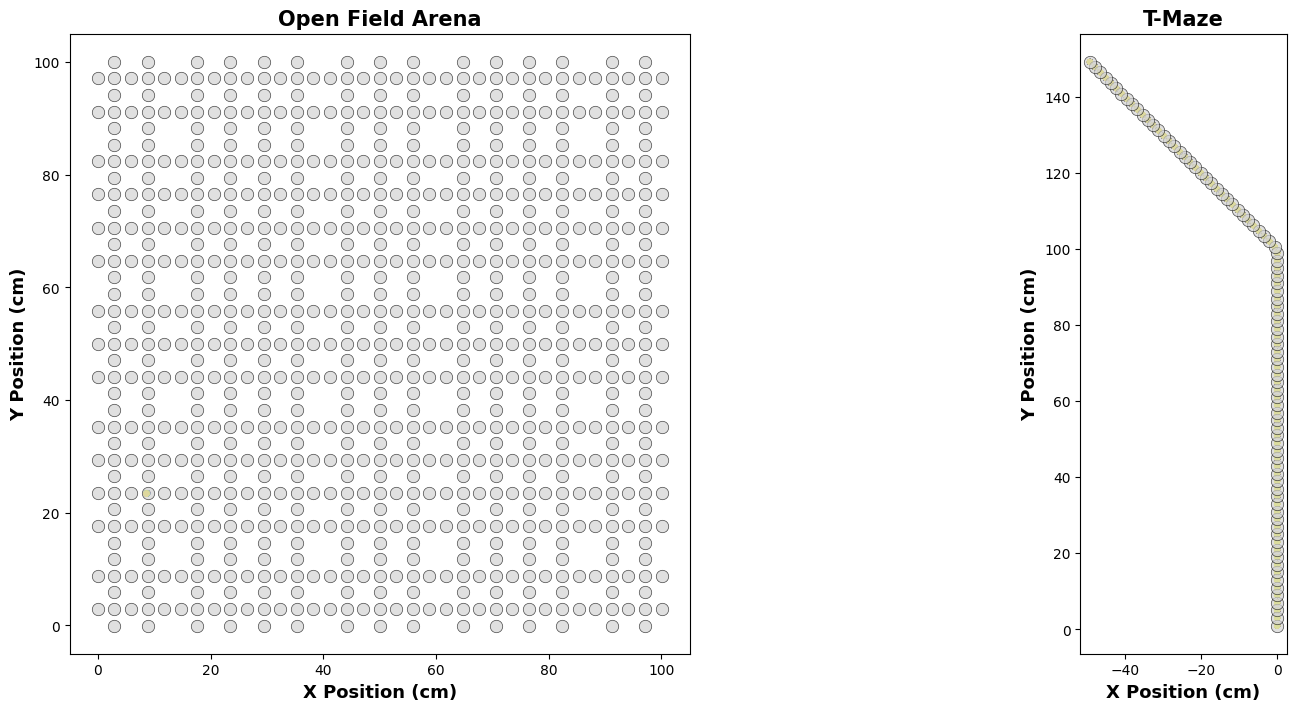

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(16, 7), constrained_layout=True)

# Open field trajectory
axes[0].scatter(
    positions[::20, 0],
    positions[::20, 1],
    c=np.arange(len(positions[::20])),
    cmap="viridis",
    s=10,
    alpha=0.5,
)
axes[0].scatter(
    env.bin_centers[:, 0],
    env.bin_centers[:, 1],
    c="lightgray",
    s=80,
    edgecolors="black",
    linewidths=0.5,
    alpha=0.7,
)
axes[0].set_xlabel("X Position (cm)", fontsize=13, fontweight="bold")
axes[0].set_ylabel("Y Position (cm)", fontsize=13, fontweight="bold")
axes[0].set_title("Open Field Arena", fontsize=15, fontweight="bold")
axes[0].set_aspect("equal")

# T-maze trajectory
axes[1].scatter(
    tmaze_positions[::10, 0],
    tmaze_positions[::10, 1],
    c=np.arange(len(tmaze_positions[::10])),
    cmap="plasma",
    s=10,
    alpha=0.5,
)
axes[1].scatter(
    tmaze_env.bin_centers[:, 0],
    tmaze_env.bin_centers[:, 1],
    c="lightgray",
    s=80,
    edgecolors="black",
    linewidths=0.5,
    alpha=0.7,
)
axes[1].set_xlabel("X Position (cm)", fontsize=13, fontweight="bold")
axes[1].set_ylabel("Y Position (cm)", fontsize=13, fontweight="bold")
axes[1].set_title("T-Maze", fontsize=15, fontweight="bold")
axes[1].set_aspect("equal")

plt.show()

### Simulate Place Cell in T-Maze

The `tmaze_alternation_session()` function has already generated place cell spike data.
The place cell was automatically positioned with uniform coverage across the T-maze.
Let's compute the firing rate map to see where the cell fired.

In [13]:
# Note: Spikes were already generated by tmaze_alternation_session()
# Extract ground truth from the session (ground_truth is a dict with keys like 'cell_0')
tmaze_ground_truth = tmaze_session.ground_truth["cell_0"]  # First cell
tmaze_field_center = tmaze_ground_truth["center"]

print(f"\nT-maze session generated {len(tmaze_spike_times)} spikes")
print(f"T-maze field center (ground truth): {tmaze_field_center}")
print(f"Field properties: {tmaze_ground_truth}")

# Compute firing rate map for T-maze
tmaze_firing_rate = compute_place_field(
    tmaze_env,
    tmaze_spike_times,
    tmaze_times,
    tmaze_positions,
    bandwidth=5.0,
)


T-maze session generated 38638 spikes
T-maze field center (ground truth): [0. 1.]
Field properties: {'center': array([0., 1.]), 'width': np.float64(5.95502365530191), 'max_rate': 20.0, 'baseline_rate': 0.001}


### Visualize Remapping: Same Cell, Two Environments

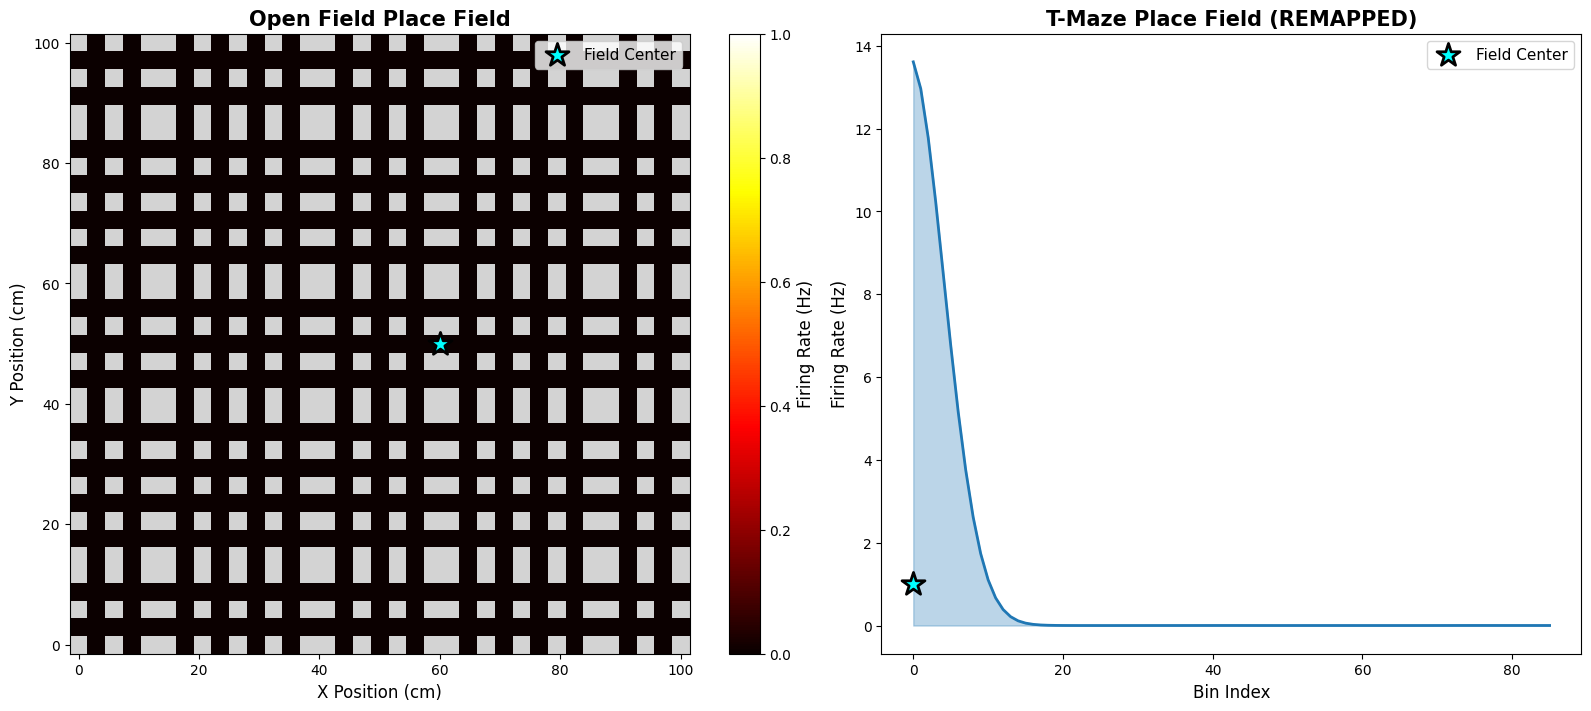


REMAPPING DETECTED
Open field center: [60. 50.]
T-maze center:     [0. 1.]
Distance moved:    77.5 cm

This demonstrates GLOBAL REMAPPING - the place field
completely reorganized in the new environment!


In [14]:
fig, axes = plt.subplots(1, 2, figsize=(16, 7), constrained_layout=True)

# Open field place field
env.plot_field(
    firing_rate,
    ax=axes[0],
    cmap="hot",
    vmin=0,
    colorbar_label="Firing Rate (Hz)",
)
axes[0].scatter(
    field_center[0],
    field_center[1],
    s=300,
    c="cyan",
    marker="*",
    edgecolors="black",
    linewidths=2,
    label="Field Center",
    zorder=10,
)
axes[0].set_title("Open Field Place Field", fontsize=15, fontweight="bold")
axes[0].legend(fontsize=11)

# T-maze place field
tmaze_env.plot_field(
    tmaze_firing_rate,
    ax=axes[1],
    cmap="hot",
    vmin=0,
    colorbar_label="Firing Rate (Hz)",
)
axes[1].scatter(
    tmaze_field_center[0],
    tmaze_field_center[1],
    s=300,
    c="cyan",
    marker="*",
    edgecolors="black",
    linewidths=2,
    label="Field Center",
    zorder=10,
)
axes[1].set_title("T-Maze Place Field (REMAPPED)", fontsize=15, fontweight="bold")
axes[1].legend(fontsize=11)

plt.show()

print("\n" + "=" * 60)
print("REMAPPING DETECTED")
print("=" * 60)
print(f"Open field center: {field_center}")
print(f"T-maze center:     {tmaze_field_center}")
print(f"Distance moved:    {np.linalg.norm(field_center - tmaze_field_center):.1f} cm")
print("\nThis demonstrates GLOBAL REMAPPING - the place field")
print("completely reorganized in the new environment!")

### Quantify Remapping with Spatial Correlation

We can't directly compare firing rates between different environments (different bin positions). Instead, we use **spatial correlation** by interpolating one map onto the other's coordinates.

For environments with overlapping spatial extent, we can:
1. Find bins that exist in both environments
2. Interpolate firing rates to common positions
3. Compute correlation

**Note**: For very different geometries (like open field vs T-maze), spatial correlation is less meaningful. Population vector correlation (across multiple cells) is more appropriate.

In [15]:
def compute_spatial_correlation_overlap(env1, rate1, env2, rate2):
    """
    Compute spatial correlation for overlapping region of two environments.

    This is a simplified approach - finds bins in env2 closest to env1 bins
    within a distance threshold.
    """
    from scipy.spatial.distance import cdist

    # Find overlapping bins (bins in env1 close to bins in env2)
    distances = cdist(env1.bin_centers, env2.bin_centers)

    # For each bin in env1, find closest bin in env2
    closest_env2_bins = np.argmin(distances, axis=1)
    min_distances = np.min(distances, axis=1)

    # Only use bins within 5 cm (approximately overlapping)
    overlap_threshold = 5.0  # cm
    overlap_mask = min_distances < overlap_threshold

    if overlap_mask.sum() < 5:
        return np.nan, 0

    # Get firing rates for overlapping bins
    rate1_overlap = rate1[overlap_mask]
    rate2_overlap = rate2[closest_env2_bins[overlap_mask]]

    # Remove NaN values
    valid = ~np.isnan(rate1_overlap) & ~np.isnan(rate2_overlap)

    if valid.sum() < 5:
        return np.nan, valid.sum()

    # Compute correlation
    corr = np.corrcoef(rate1_overlap[valid], rate2_overlap[valid])[0, 1]

    return corr, valid.sum()


# Compute spatial correlation
spatial_corr, n_overlap = compute_spatial_correlation_overlap(
    env, firing_rate, tmaze_env, tmaze_firing_rate
)

print("\nSpatial Correlation (Remapping Metric):")
print(f"  Correlation: {spatial_corr:.3f}")
print(f"  Overlapping bins: {n_overlap}")
print("\nInterpretation:")
print("  > 0.7: Same place field (stable)")
print("  0.3-0.7: Partial remapping")
print("  < 0.3: Complete remapping (this cell)")


Spatial Correlation (Remapping Metric):
  Correlation: nan
  Overlapping bins: 50

Interpretation:
  > 0.7: Same place field (stable)
  0.3-0.7: Partial remapping
  < 0.3: Complete remapping (this cell)


/Users/edeno/Documents/GitHub/neurospatial/.venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/edeno/Documents/GitHub/neurospatial/.venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


## Summary

In this notebook, we demonstrated:

1. **Firing Rate Computation**: Converting spike trains to spatial maps with occupancy normalization
2. **Place Field Detection**: Automatic identification using peak-based segmentation
3. **Field Properties**: Computing size and centroid for each field
4. **Spatial Metrics**: Skaggs information and sparsity for quantifying spatial coding
5. **Stability Analysis**: Split-half correlation to assess field reliability
6. **Complete Workflow**: End-to-end analysis function
7. **T-Maze Analysis**: Working with irregular environments
8. **Place Remapping**: Quantifying how place fields change between environments

### Key Functions Used

- `compute_place_field()` - Spike train → firing rate map
- `detect_place_fields()` - Automatic field detection
- `field_size()` - Field area in physical units
- `field_centroid()` - Center of mass
- `skaggs_information()` - Spatial information (bits/spike)
- `sparsity()` - Firing sparsity [0, 1]
- `field_stability()` - Temporal stability (correlation)

### References

- O'Keefe & Dostrovsky (1971): Discovery of place cells
- Skaggs et al. (1993): Spatial information metric
- Skaggs et al. (1996): Sparsity metric
- Muller & Kubie (1987, 1989): Place field characterization
- Wilson & McNaughton (1993): Population dynamics

### Next Steps

- Try with real experimental data
- Analyze populations of place cells (see population metrics)
- Compare place fields across conditions
- Analyze boundary cells (see boundary cell notebook)